# Sandmining Project Takehome Assessment Final Report

- __Author__: Sushant Harischandra Vema. 
<br> - Developed between December 17th 2023 to January 15th 2024. 
<br> - The task attempted in this project was inspired and designed by Ando Shah.

__Mission Statement__: *Implement a semantic segmentation model trained on Sentinel-2 satellite imagery to predict illegal sandmining operations in India.*

![system_diagram.png](/Users/sashikanth/Documents/sushi/sushi_personal/sandmining_prediction/system_diagram.png)

In [1]:
from IPython.display import Markdown as md

from sandmining.load_observations import load_observations
from sandmining.process_annotations import process_annotations
from sandmining.dataset import PatchDataset
from sandmining.train_model import train_model
from sandmining.inference import evaluate_model
from sandmining.visualizations import side_by_side_visualizations
from project_config import *

/Users/sashikanth/Documents/sushi/sushi_personal/sandmining_prediction/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## A: Relevant Project-Level Parameters

Whenever I refer to a variable with a NAME_IN_ALL_CAPS, it is a project-level parameter whose value can be found in project_config.py. Below is a preview of the parameters I have enumerated. Each reference to project-level parameters in this report will contain useful contextual information about its purpose.

Note: I have opted to use pathlib.Path directories for easy interpretability and inter-OS compatibility. 

In [12]:
!cat /Users/sashikanth/Documents/sushi/sushi_personal/sandmining_prediction/project_config.py

from pathlib import Path

# Data Directory
PACKAGE_DIRECTORY = Path.cwd() / 'sandmining'
DATA_DIRECTORY = PACKAGE_DIRECTORY / 'data'

# Observation Directories
OBSERVATIONS_JSON = DATA_DIRECTORY / 'observations.json'
OBS_0_DIRECTORY = DATA_DIRECTORY / 'Observation0'
OBS_1_DIRECTORY = DATA_DIRECTORY / 'Observation1'
OBS_2_DIRECTORY = DATA_DIRECTORY / 'Observation2'

# Models Directory
MODELS_DIRECTORY = PACKAGE_DIRECTORY / 'models'

# Output Directory
OUTPUT_DIRECTORY = PACKAGE_DIRECTORY / 'image_outputs'

# Data Preprocessing Parameters
IN_RIVER_BOUNDS_THRESHOLD = 0.85

# Model Parameters
NUM_CHANNELS = 3
NUM_CLASSES = 1

# Model Training Parameters
OBSERVATIONS_FOR_TRAINING = [OBS_0_DIRECTORY, OBS_1_DIRECTORY]
NUM_EPOCHS = 1
BATCH_SIZE = 4
SAMPLES_TO_TRAIN_PER_OBSERVATION = 1000
SAMPLES_PER_SAVE_WEIGHTS = 96

# Inference / Evaluation Parameters
OBSERVATION_FOR_EVALUATION = OBS_2_DIRECTORY
MODEL_TO_USE = "unetplusplus_2024-01-11_1_240_1704963006.pth" 
NUM_SAMPLES = 3000 
PREDICTION_THR

## B: Load the Data

Download .tif RGB source images, label annotations, and river boundaries geojson files from the google cloud bucket. Save them in relevant data directories. 

NOTE: I opted to use the RGB source images instead of 12-band source images in order to build my version 1 system. As far as I can tell, it wouldn't be difficult for me to pivot to the 12-band data for training and inference, as I would only have to change the input channels of the model and do a bit of high-dimensional data normalization. However, I thought the computational burden would be too much for me and would distract from the purpose of this project. On the other hand, maybe the richness of information would allow our learning scheme to be more sample efficient than with using only RGB images. 

In [2]:
load_observations()

-------------
Loading data from sources.
-------------
Ingested data for Observation {'uri_to_s1': 'https://storage.googleapis.com/sand_mining_median/labels/Bhargavi_Khordha_85-88_20-26_median/s1/Bhargavi_Khordha_85-88_20-26_2018-12-01_s1.tif', 'uri_to_s2': 'https://storage.googleapis.com/sand_mining_median/labels/Bhargavi_Khordha_85-88_20-26_median/s2/Bhargavi_Khordha_85-88_20-26_2018-12-01_s2.tif', 'uri_to_s2_l1c': 'https://storage.googleapis.com/sand_mining_median/labels/Bhargavi_Khordha_85-88_20-26_median/s2_l1c/Bhargavi_Khordha_85-88_20-26_2018-12-01_s2_l1c.tif', 'uri_to_rgb': 'https://storage.googleapis.com/sand_mining_median/labels/Bhargavi_Khordha_85-88_20-26_median/rgb/Bhargavi_Khordha_85-88_20-26_2018-12-01_rgb.tif', 'uri_to_annotations': 'https://storage.googleapis.com/sand_mining_median/labels/Bhargavi_Khordha_85-88_20-26_median/annotations/Bhargavi_Khordha_85-88_20-26_2018-12-01_annotations_3class.geojson', 'uri_to_rivers': 'https://storage.googleapis.com/sand_mining_media

## C: Preprocess Label Annotations and River Polygons

Convert geojson FeatureSets into geopandas GeoDataFrame's and set the appropriate coordinate system for labels and rivers. Convert these polygon sets into boolean mask rasters matching the dimensions of the original .tif source image. Use rasterio's rasterize function to "fill in" polygons so that the boolean raster masks have solid shapes instead of just boundaries. 

In [2]:
process_annotations()

-------------
Generating binary masks for label annotations and river borders for each observation.
-------------
Created masks and persisted them in relevant data directories.


## D: Train the Model (Using heavily preprocessed data)

### D.1: UnetPlusPlus

I picked an off the shelf pytorch implementation of Unet called UnetPlusPlus for this semantic segmentation task for the following reasons. It's architectural features allow it to handle multi-class segmentation with ease, be robust to variations in image size and content, be effective for limited training data scenarios, and versatile for a variety of segmentation tasks. 

The encoder and decoder structures (downsampling and upsampling paths) allow the model to extract high level information about image content and to synthesize low level features with decoder features for better localization. This is paired with skip connections which help preserve boundary information and enhance localization accuracy. It also helps with training by mitigating the vanishing gradient problem. Lastly, fully convolutional layers in conjunction with the encoder decoder architecture allow for pixel-wise segmentation and context aggregation. 

I used a pre-trained UnetPlusPlus model with Imagenet weights for the encoder, as well as a sigmoid activation function for the output layer. 

### D.2 Data Preprocessing within PatchDataset

I implemented a custom pytorch Dataset (aka PatchDataset) with the following capabilities: 

1. Pre-hoc collection and persistence of "valid" zero-indexed sample indices of patches within river bounds. I have limited collection to ~50000 unique valid patches in any observation – there are many many more. Due to the nature of random sampling, I believe this provides sufficient data to approximate in- and out-of-class distributions for the purposes of inference.
2. Uniform random patch sampling of the source image using a special sliding window algorithm.
3. Return sampled sliding window patches *only within river bounds* based on whether at least **IN_RIVER_BOUNDS_THRESHOLD**% of the pixels in the patch is within the river polygon. (See point 1)
4. Bridges the gap between boundary + label rasters and source images, returning bounding box coordinates for sampled patches.

Implementing PatchDataset correctly took at least 50% of my time, allowing me to accomplish most of the stretch goals and enabling me to seamlessly scale up my training and inferencing (ML experimentation) if need be.

### D.3: Training Infrastructure and Learning Algorithm Specification

The model is trained on **OBSERVATIONS_FOR_TRAINING** and evaluated on a held out **OBSERVATION_FOR_EVALUATION**. The model is trained for **NUM_EPOCHS** with batches of size **BATCH_SIZE**. Due to computational constraints (CPU on my laptop), the model is only trained on **SAMPLES_TO_TRAIN_PER_OBSERVATION** number of samples per obs in **OBSERVATIONS_FOR_TRAINING**. Updated model weights are persisted every **SAMPLES_PER_SAVE_WEIGHTS** number of samples.

I'm using the standard Adam optimizer. I have implemented a loss function called Dice Loss. Dice Loss is a measure of the dissimilarity between the predicted segmentation and the true segmentation of an image. It compares the similarity of two binary classifications of an image: the true segmentation, and the predicted segmentation generated by a machine learning model. The goal is to minimize the difference between the two segmentations, which is called the loss function. Dice Loss is particularly useful when dealing with imbalanced datasets, where the positive and negative classes are not evenly distributed. Since Dice Loss takes into account both the predicted and true segmentation values, it can help prevent the model from favoring one class over the other. In our case, background values are far more prevalent than label values which makes Dice Loss a good choice.

In [2]:
train_model('unetplusplus')

-------------
Training unetplusplus for 1 epoch.
Loss function: DiceLoss
Optimizer: Adam
-------------
Start training with observation 0
Lower bound on the total number of valid samples we can train from for observation 0: 50001.
Processed 0 samples out of 1000 slated for training.
Saving intermediate model
Processed 96 samples out of 1000 slated for training.
Saving intermediate model
Processed 192 samples out of 1000 slated for training.
Saving intermediate model
Processed 288 samples out of 1000 slated for training.
Saving intermediate model
Processed 384 samples out of 1000 slated for training.
Saving intermediate model
Processed 480 samples out of 1000 slated for training.
Saving intermediate model
Processed 576 samples out of 1000 slated for training.
Saving intermediate model
Processed 672 samples out of 1000 slated for training.
Saving intermediate model
Processed 768 samples out of 1000 slated for training.
Saving intermediate model
Processed 864 samples out of 1000 slated for

## E. Evaluate the model on held out observation and visualize predictions.

Inferencing on all 50000 valid patches in an image is not feasible. Instead I chose **NUM_SAMPLES** random valid patches from the list of valid patches for **OBSERVATION_FOR_EVALUATION**. I then stitched the resulting predictions back together to create an image mask with the same dimensions as the original test image. The idea behind using a large random sample of valid patches is that the areas which happen to overlap between inferenced patches will "ensemble together" such that any predicted labels in that overlap area represent something of a "low bound" or "conservative estimate" of there being a sandmine or not.

The evaluate_model function instantiates a model from **MODEL_TO_USE** weights file. If predict_uniformly=True, then the aforementioned sampling/stitching scheme comes into play. Otherwise, only 10 sample patches will be inferenced and visualized.

In [2]:
evaluate_model(predict_uniformly=True)

-------------
Observation to evaluate: /Users/sashikanth/Documents/sushi/sushi_personal/sandmining_prediction/sandmining/data/Observation2
Uniform random sampling?: True
Model to use: unetplusplus_2024-01-13_1_240_1705139266.pth
Prediction Threshold: 0.85
Number of samples to inference on: 3000
-------------
0 patches accumulated.
100 patches accumulated.
200 patches accumulated.
300 patches accumulated.
400 patches accumulated.
500 patches accumulated.
600 patches accumulated.
700 patches accumulated.
800 patches accumulated.
900 patches accumulated.
1000 patches accumulated.
1100 patches accumulated.
1200 patches accumulated.
1300 patches accumulated.
1400 patches accumulated.
1500 patches accumulated.
1600 patches accumulated.
1700 patches accumulated.
1800 patches accumulated.
1900 patches accumulated.
2000 patches accumulated.
2100 patches accumulated.
2200 patches accumulated.
2300 patches accumulated.
2400 patches accumulated.
2500 patches accumulated.
2600 patches accumulated.


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


50 patches inferenced.
100 patches inferenced.
150 patches inferenced.
200 patches inferenced.
250 patches inferenced.
300 patches inferenced.
350 patches inferenced.
400 patches inferenced.
450 patches inferenced.
500 patches inferenced.
550 patches inferenced.
600 patches inferenced.
650 patches inferenced.
700 patches inferenced.
750 patches inferenced.
800 patches inferenced.
850 patches inferenced.
900 patches inferenced.
950 patches inferenced.
1000 patches inferenced.
1050 patches inferenced.
1100 patches inferenced.
1150 patches inferenced.
1200 patches inferenced.
1250 patches inferenced.
1300 patches inferenced.
1350 patches inferenced.
1400 patches inferenced.
1450 patches inferenced.
1500 patches inferenced.
1550 patches inferenced.
1600 patches inferenced.
1650 patches inferenced.
1700 patches inferenced.
1750 patches inferenced.
1800 patches inferenced.
1850 patches inferenced.
1900 patches inferenced.
1950 patches inferenced.
2000 patches inferenced.
2050 patches inferen

### E.1: Side-by-side visualizations

The below figure represents the model's performance on the held out observation (Observation 2) as compared to the ground truth labels. 
1. The topmost image is the source image with an overlay of the river boundaries within which I sampled from.
2. The middle image is the ground truth labels.
3. The bottom image is the "stitched" set of predictions our model made using a uniform random patch sampling scheme with N = NUM_SAMPLES. As N increases, the resulting stitched image approximates the stitched image with a complete sliding window algorithm.

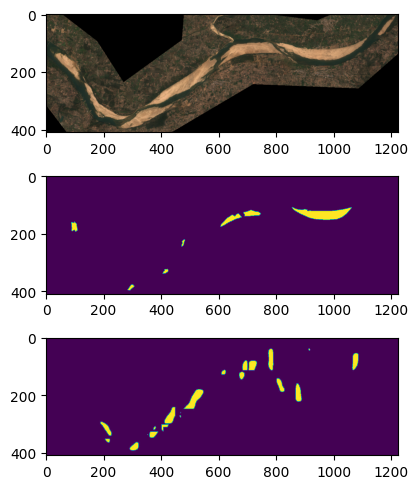

In [2]:
side_by_side_visualizations(OBSERVATION_FOR_EVALUATION, OUTPUT_DIRECTORY)

## F. Final Thoughts

### F.1: Overall Learning

This was the first computer vision project I've worked on before. I learned about remote sensing, semantic segmentation, working with geo data (polygons, rasters, images, coordinates, and associated Python modules), different loss functions for these applications, the power of custom data loaders and samplers, and much much more. It has been a tremendous learning experience. 

### F.2: Model Performance

Very pleasantly surprised! Given: the sparsity of labels in our observations, only using RGB streams of input data, an off the shelf introductory segmentation model, and a custom region-based loss function, I was able to achieve predictions that, when stitched together, that were definitely on the right track (this is my subjective analysis).

Clearly this is a complicated computer vision problem. Label sparsity + human expert-labeling poses unique challenges for inference. However, with advances in segmentation modeling, high dimensional data computation, sampling theory, and labeling schemes, problems like these have tremendous scope.

Additionally, with only 1 epoch of training in this example, there are possibilities for clever optimization algorithms to focus on select patches which are inferenced poorly between epochs. 

### F.3: Tools Used

I made extensive use of Stack Overflow, Google Bard, ChatGPT, various package documentation, Medium articles, and more in order to dive deep into computer vision and get my hands dirty with building pytorch ecosystems for CV applications. 

I tried to use best practices when building this repository as well as the sandmining package. I'm a big fan of scripting, command-line programming, and local debugging with ipdb. I put together this notebook / report after building and testing all the parts of the sandmining package, which comes with a simple commandline tool main.py. The repository is meant to be scalable and easy to hand over. 

### F.4: Hypothetical Next Steps
- Experiment with other off-the-shelf semantic segmentation models such as DeepLabV3 and a simple fully-convolutional network.
- Run this on a cloud instance with GPU, allowing me to train multiple epochs with more training data and larger batch sizes. 
- Experiment with the full spectra data from S1 and S2 satellites instead of just RGB.
- Consider other image preprocessing techniques such as normalization.
- Consider more sophisticated sampling strategies to deal with class imbalance and localization.
- Run some basic hyperparameter tuning with learning algorithm parameters. 
- Look into various metrics to measure in semantic segmentation applications.